# Overview of Conversational Intelligence Challenge 1st Roud Dataset

In [2]:
from __future__ import division, print_function
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict
from nltk import wordpunct_tokenize
from scipy.stats import pearsonr, spearmanr

In [5]:
with open("data/train_full.json") as f:
    dataset = json.load(f)

In [6]:
human_human, human_bot = np.zeros((len(dataset), )), np.zeros((len(dataset), ))
for i, d in enumerate(dataset):
    human, bot = 0, 0
    for u in d['users']:
        if u['userType'] == 'Human':
            human += 1
        elif u['userType'] == 'Bot':
            bot += 1
        else:
            print('Unknown user type: {}'.format(u['userType']))
    if human == 2:
        human_human[i] = 1
    elif human == 1 and bot == 1:
        human_bot[i] = 1
    else:
        print('Unknown combination of users: human = {}, bot = {}'.format(human, bot))

## 1. Dialogue statistics

In [8]:
silent_user = []
long_dialogue = []
empty_dialogue = []
for i, d in enumerate(dataset):
    user_utt = defaultdict(int)
    user_map = {}
    if len(d['thread']) == 0:
        empty_dialogue.append(i)
        continue
    for th in d['thread']:
        user_utt[th['userId']] += 1
    for u in d['users']:
        if u['userType'] == 'Human':
            user_map[u['id']] = 'human'
        elif u['userType'] == 'Bot':
            user_map[u['id']] = 'bot'
        else:
            print('Unknown user type: {}'.format(u['userType']))
    for u in user_map:
        if u not in user_utt:
            silent_user.append(i)
            break
    ok = False
    for u in user_map:
        if user_utt[u] > 2:
            if ok:
                long_dialogue.append(i)
            else:
                ok = True

### 1.1 Length of dialogues

In [9]:
print('\t\t\tTotal\tHuman-to-bot\tHuman-to-human')

# Total
hh_dialog = [d for i, d in enumerate(dataset) if human_human[i] == 1]
hb_dialog = [d for i, d in enumerate(dataset) if human_bot[i] == 1]
print('All dialogues\t\t{}\t\t{}\t\t{}'.format(len(dataset), len(hh_dialog), len(hb_dialog)))

# Empty
hh_empty = [d for i, d in enumerate(empty_dialogue) if human_human[i] == 1]
hb_emtpy = [d for i, d in enumerate(empty_dialogue) if human_bot[i] == 1]
print('Empty dialogues\t\t{}\t\t{}\t\t{}'.format(len(empty_dialogue), len(hh_empty), len(hb_emtpy)))

# One-sided
hh_silent = [d for i, d in enumerate(silent_user) if human_human[i] == 1]
hb_silent = [d for i, d in enumerate(silent_user) if human_bot[i] == 1]
print('One-sided dialogues\t{}\t\t{}\t\t{}'.format(len(silent_user), len(hh_silent), len(hb_silent)))

# Long dialogues
hh_long = [d for i, d in enumerate(long_dialogue) if human_human[i] == 1]
hb_long = [d for i, d in enumerate(long_dialogue) if human_bot[i] == 1]
print('Long dialogues\t\t{}\t\t{}\t\t{}'.format(len(long_dialogue), len(hh_long), len(hb_long)))

			Total	Human-to-bot	Human-to-human
All dialogues		2778		441		2337
Empty dialogues		119		66		53
One-sided dialogues	560		229		331
Long dialogues		1719		368		1351


### 1.2 Length of utterances

In [ ]:
n_words, n_utt = [],[]
word_in_utt = []
word_in_utt_hier = []
for d in dataset:
    cur_utt = 0
    cur_words = 0
    cur_w_i_u = []
    for th in d['thread']:    
        text = wordpunct_tokenize(th['text'])
        cur_utt += 1
        cur_words += len(text)
        word_in_utt.append(len(text))
        cur_w_i_u.append(len(text))
    n_words.append(cur_words)
    n_utt.append(cur_utt)
    word_in_utt_hier.append(cur_w_i_u)
word_per_utt = [float(w)/float(u) if u > 0 else 0 for w, u in zip(n_words, n_utt)]
filter_word_per_utt = [f for f in word_per_utt if f < 25]
plot = plt.hist(filter_word_per_utt, bins=25)

In [ ]:
print('\t\t\tTotal\t\tHuman-to-bot\tHuman-to-human')

hh_utt = [d for i, d in enumerate(n_utt) if human_human[i] == 1]
hb_utt = [d for i, d in enumerate(n_utt) if human_bot[i] == 1]
print('Utt. per dialogue\t%.2f\t\t%.2f\t\t%.2f' % (np.average(n_utt), np.average(hb_utt), np.average(hh_utt)))

hh_word = [np.average(d) if len(d) > 0 else 0 for i, d in enumerate(word_in_utt_hier) if human_human[i] == 1]
hb_word = [np.average(d) if len(d) > 0 else 0 for i, d in enumerate(word_in_utt_hier) if human_bot[i] == 1]
print('Word per utt.\t\t%.2f\t\t%.2f\t\t%.2f' % (np.average(word_in_utt), np.average(hb_word), np.average(hh_word)))

In [ ]:
human_lens = []
bot_lens = []
for d in dataset:
    user_type = {}
    for user in d["users"]:
        if user["userType"] == 'Bot':
            user_type[user['id']] = False
        elif user["userType"] == 'Human':
            user_type[user['id']] = True
    for th in d["thread"]:
        if user_type[th["userId"]]:
            human_lens.append(len(th["text"]))
        else:
            bot_lens.append(len(th["text"]))
plot = plt.hist((human_lens,bot_lens), bins=10, range=(0,200), label = ('human','bot'))
plt.xlabel('Length of utterance in characters')
plt.ylabel('Frequency')
l = plt.legend()

## 2. Evaluation of dialogues

### 2.1 Dialogue-level quality

In [ ]:
human_qual, bot_qual = [], []
for i, d in enumerate(dataset):
    users_map = {}
    uids = []
    users_scores = defaultdict(list)
    dbl = False
    for u in d['users']:
        uids.append(u['id'])
        if u['userType'] == 'Human':
            users_map[u['id']] = True
        elif u['userType'] == 'Bot':
            users_map[u['id']] = False
    if users_map[uids[0]] and users_map[uids[1]]:
        dbl = True
    #print(users_map)
    for ev in d['evaluation']:
        if dbl:
            human_qual.append(ev['quality'])
            continue
        if (ev['userId'] == uids[0] and not users_map[uids[0]]) or (ev['userId'] == uids[1] and not users_map[uids[1]]):
            bot_qual.append(ev['quality'])

plot = plt.hist(human_qual, bins=5, histtype='step', linewidth=3.0, label='human')
plot = plt.hist(bot_qual, bins=5, histtype='step', linewidth=3.0, label='bot')
plt.xlabel('Dialogue-level quality')
plt.ylabel('Frequency')
l = plt.legend()
#sum(bot_qual), len(bot_qual), len(human_qual)

In [ ]:
plot = plt.hist(human_qual + bot_qual, bins=5)
plt.xlabel('Dialogue-level quality')
plt.ylabel('Number of dialogues')

#### Correlation of dialogue-level scores

In [ ]:
breadth, engagement, quality = [], [], []
qu_dbl = [[], []]
for d in dataset:
    dbl = False
    users_map = {}
    uids = []
    users_scores = defaultdict(list)
    for u in d['users']:
        uids.append(u['id'])
        if u['userType'] == 'Human':
            users_map[u['id']] = True
        elif u['userType'] == 'Bot':
            users_map[u['id']] = False
    if users_map[uids[0]] and users_map[uids[1]]:
        dbl = True
    cur_dbl_q, cur_dbl_br, cur_dbl_en = [], [], []
    for i, ev in enumerate(d['evaluation']):
        if dbl:
            cur_dbl_q.append(ev['quality'])
            cur_dbl_br.append(ev['breadth'])
            cur_dbl_en.append(ev['engagement'])
        if (ev['userId'] == uids[0] and not users_map[uids[0]]) or (ev['userId'] == uids[1] and not users_map[uids[1]]):
            breadth.append(ev['breadth'])
            engagement.append(ev['engagement'])
            quality.append(ev['quality'])
            break
    if dbl:
        breadth.append(np.average(cur_dbl_br))
        quality.append(np.average(cur_dbl_q))
        engagement.append(np.average(cur_dbl_en))
print('Breadth vs quality: ', pearsonr(breadth, quality)[0])
print('Engagement vs quality', pearsonr(engagement, quality)[0])
print('Breadth vs engagement', pearsonr(breadth, engagement)[0])

### 2.2 Utterance-level quality

In [ ]:
human_utt, bot_utt = [], []
for i, d in enumerate(dataset):
    users = {}
    for u in d['users']:
        if u['userType'] == 'Human':
            users[u['id']] = 'human'
        elif u['userType'] == 'Bot':
            users[u['id']] = 'bot'
    for th in d['thread']:
        if th['evaluation'] != 0:
            try:
                if users[th['userId']] == 'human':
                    human_utt.append(th['evaluation'] - 1)
                elif users[th['userId']] == 'bot':
                    bot_utt.append(th['evaluation'] - 1)
            except KeyError:
                print('Unknown user {} in dialogue {}'.format(th['userId'], i))
fig, ax = plt.subplots()

h_avg, h_std = np.average(human_utt), np.std(human_utt)
b_avg, b_std = np.average(bot_utt), np.std(bot_utt)
human_utt_trans = [(h - h_avg)/h_std for h in human_utt]
bot_utt_trans = [(b - b_avg)/b_std for b in bot_utt]
ax.hist((human_utt, bot_utt), bins=2, label=('human', 'bot'))
l = plt.legend()
plt.xlabel('Utterance-level scores')
plt.ylabel('Frequency')
plt.show()

#### Distribution of dialogues by number of utterance-level scores

In [ ]:
rated_utt = {}
rated_utt_detailed = []
all_human_eval = []
for i, d in enumerate(dataset):
    cur_rated = []
    cur_rated_user1, cur_rated_user2 = [], []
    users = {}
    for u in d['users']:
        if u['userType'] == 'Human':
            users[u['id']] = 'human'
        elif u['userType'] == 'Bot':
            users[u['id']] = 'bot'
    [user1, user2] = users.keys()
    #print(user1, user2)
    for th in d['thread']:
        if human_human[i]:
            cur_rated.append(th['evaluation'])
            all_human_eval.append(th['evaluation'])
            #print(users[th['userId']], user1, user2)
            if th['userId'] == user1:
                cur_rated_user1.append(th['evaluation'])
            elif th['userId'] == user2:
                cur_rated_user2.append(th['evaluation'])
        elif users[th['userId']] == 'bot':
            cur_rated.append(th['evaluation'])
            all_human_eval.append(th['evaluation'])
            
    percent = sum([1 for c in cur_rated if c != 0])/len(cur_rated) if len(cur_rated) > 0 else 0
    rated_utt[i] = percent
    if human_human[i]:
        rated_utt_detailed.append(cur_rated_user1)
        rated_utt_detailed.append(cur_rated_user2)
        #print('Dialogue {}, user1: '.format(i), cur_rated_user1)
        #print('Dialogue {}, user2: '.format(i), cur_rated_user2)
    else:
        rated_utt_detailed.append(cur_rated)
        #print('Dialogue {}'.format(i), cur_rated)

plot = plt.hist(rated_utt.values(), bins=11)
plt.xlabel('Percentage of rated utterances in dialogue')
plt.ylabel('Number of dialogues')
num_unrated = len([t for t in all_human_eval if t == 0])
print('Number of unrated utterances: {} ({}%)'.format(num_unrated, 100*num_unrated/len(all_human_eval)))
num_unrated_dial = len([t for t in rated_utt.values() if t == 0])
print('Number of dialogues with zero rated utterances: {} ({}%)'.format(num_unrated_dial, 100*num_unrated_dial/len(rated_utt)))
num_incomplete = len([t for t in rated_utt.values() if t > 0 and t < 1])
print('Number of dialogues with partially rated utterances: {} ({}%)'.format(num_incomplete, 100*num_incomplete/len(rated_utt)))
print(max([len(dl) for dl in rated_utt_detailed]))

In [ ]:
dataset[33]

In [ ]:
rated_long = {k: v for k, v in rated_utt.items() if k in long_dialogue}
one_rated_human = [v for k, v in rated_long.items() if human_human[k] and v > 0]
one_rated_bot = [v for k, v in rated_long.items() if human_bot[k] and v > 0]
half_rated_human = [v for k, v in rated_long.items() if human_human[k] and v >= 0.5]
half_rated_bot = [v for k, v in rated_long.items() if human_bot[k] and v >= 0.5]
all_rated_human = [v for k, v in rated_long.items() if human_human[k] and v == 1]
all_rated_bot = [v for k, v in rated_long.items() if human_bot[k] and v == 1]
one_rated = len(one_rated_human) + len(one_rated_bot)
half_rated = len(half_rated_human) + len(half_rated_bot)
all_rated = len(all_rated_human) + len(all_rated_bot)
print('Long & at least one item rated\t\t{}\t\t{}\t\t{}'.format(one_rated, len(one_rated_human), len(one_rated_bot)))
print('Long & at least half items rated\t{}\t\t{}\t\t{}'.format(half_rated, len(half_rated_human), len(half_rated_bot)))
print('Long & all items rated\t\t\t{}\t\t{}\t\t{}'.format(all_rated, len(all_rated_human), len(all_rated_bot)))
print('Average percentage of rated utterances for dialogues with at least one utterance rated: {}'.format(
    np.average(one_rated_bot + one_rated_human)))

#### Distribution of utterance-level scores across dialogue

### 2.3 Dialogue-level vs utterance-level

In [ ]:
dialog_scores, utterance_scores = [], []
for d in dataset:
    cur_d, cur_u = [], []
    # dialogue-level
    for ev in d['evaluation']:
        for k in ['breadth', 'engagement', 'quality']:
        #for k in ['quality']:
            if ev[k] != 0:
                cur_d.append(ev[k])
    # utterance-level
    for th in d['thread']:
        if th['evaluation'] != 0:
            cur_u.append(th['evaluation']-1)
    dialog_scores.append(cur_d)
    utterance_scores.append(cur_u)
filter_dialog_scores = [np.average(d_s) for d_s, u_s in zip(dialog_scores, utterance_scores) if len(d_s) != 0 and len(u_s) != 0]
filter_utt_scores = [np.average(u_s) for d_s, u_s in zip(dialog_scores, utterance_scores) if len(d_s) != 0 and len(u_s) != 0]
filter_quality = [q for q, u in zip(quality, utterance_scores) if len(u) != 0]
filter_breadth = [q for q, u in zip(breadth, utterance_scores) if len(u) != 0]
filter_engagement = [q for q, u in zip(engagement, utterance_scores) if len(u) != 0]
filter_utt = [np.average(u) for u in utterance_scores if len(u) != 0]
assert(len(filter_dialog_scores) == len(filter_utt_scores))
#print(len(filter_dialog_scores))
print('Pearson r of averaged dialogue-level and utterance-level scores: ', pearsonr(filter_dialog_scores, filter_utt_scores)[0])
print('Pearson r of dialogue quality and utterance-level scores: ', pearsonr(filter_quality, filter_utt)[0])
print('Pearson r of dialogue breadth and utterance-level scores: ', pearsonr(filter_breadth, filter_utt)[0])
print('Pearson r of dialogue engagement and utterance-level scores: ', pearsonr(filter_engagement, filter_utt)[0])
plt.scatter(filter_dialog_scores, filter_utt_scores)
plt.xlabel('Dialogue-level quality')
p = plt.ylabel('Utterance-level quality')

### 2.4 Dialogue-level vs statistics

In [ ]:
all_words = []
for d in dataset:
    cur_w = []
    for th in d['thread']:
        cur_w.extend(wordpunct_tokenize(th['text'].lower()))
    all_words.append(cur_w)
unique_words = [len(list(set(cur_w))) for cur_w in all_words]
print('Correlation of quality and # of unique words: ', pearsonr(quality, unique_words)[0])
print('Correlation of breadth and # of unique words: ', pearsonr(breadth, unique_words)[0])
print('Correlation of engagement and # of unique words: ', pearsonr(engagement, unique_words)[0])

all_dialog_lens = [len(d['thread']) for d in dataset]
print('\nCorrelation of quality and # of utterances', pearsonr(quality, all_dialog_lens)[0])
print('Correlation of breadth and # of utterances', pearsonr(breadth, all_dialog_lens)[0])
print('Correlation of engagement and # of utterances', pearsonr(engagement, all_dialog_lens)[0])

In [ ]:
from nltk import ngrams
from collections import Counter
from nltk import wordpunct_tokenize
def ngram_count(dialogue, order):
    total = []
    for th in dialogue['thread']:
        ngrams_txt = ngrams(wordpunct_tokenize(th['text']), order)
        total.extend(ngrams_txt)
    cc_total = Counter(total)
    return cc_total

trigram_distr = [len(ngram_count(d, 3)) for d in dataset]
fourgram_distr = [len(ngram_count(d, 4)) for d in dataset]
fivegram_distr = [len(ngram_count(d, 5)) for d in dataset]

print('Correlation of quality and # of unique trigrams: ', pearsonr(trigram_distr, quality)[0])
print('Correlation of breadth and # of unique trigrams: ', pearsonr(trigram_distr, breadth)[0])
print('Correlation of engagement and # of unique trigrams: ', pearsonr(trigram_distr, engagement)[0])

## 3. Topicality of conversations

In [ ]:
# Do the users or bots use context as a topic for conversations?
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

all_contexts = []
all_contexts_trans = []
for d in dataset:
    all_contexts.append(d['context'])

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, PorterStemmer())
    return stems

for cont in all_contexts:
    lowers = cont.lower()
    no_punctuation = ''.join([l for l in lowers if l not in string.punctuation])
    all_contexts_trans.append(no_punctuation)
        
#this can take some time
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
tfs = tfidf.fit_transform(all_contexts_trans)

In [ ]:
# get words from the most informative (according to tf-idf) context word list that occur in the dialogue
def get_intersections(sentences, context):
    tr_table = {s: "" for s in string.punctuation}
    feature_names = tfidf.get_feature_names()
    response = tfidf.transform([context])
    words_from_cont = []
    for s in sentences:
        lowers = s.lower()
        no_punctuation = ''.join([l for l in lowers if l not in string.punctuation])
        txt = tokenize(no_punctuation)
        top15 = sorted([(feature_names[c], response[0,c]) for c in response.nonzero()[1]], reverse=True)[:15]
        cont_words = [w for w, c in top15]
        txt_common = [t for t in txt if t in cont_words]
        words_from_cont.extend(txt_common)
    return words_from_cont

all_common_words = []
for i, d in enumerate(dataset):
    all_utt = [th['text'] for th in d['thread']]
    ss = get_intersections(all_utt, all_contexts[i])
    all_common_words.append(ss)

all_lens = [len(a) for a in all_common_words]
print('Min. number of topic words: ', min(all_lens))
print('Max. number of topic words: ', max(all_lens))
print('Average number of topic words: {}, std.deviation: {}'.format(np.average(all_lens), np.std(all_lens)))

In [ ]:
all_lens_below_30 = [a for a in all_lens if a < 30]
plot = plt.hist(all_lens_below_30, bins=30)
plt.xlabel('Number of words')
p = plt.ylabel('Number of dialogues')

In [ ]:
print('Correlation of dialogue-level quality and topicality: ', pearsonr(quality, all_lens)[0])
print('Correlation of dialogue-level breadth and topicality: ', pearsonr(breadth, all_lens)[0])
print('Correlation of dialogue-level engagement and topicality: ', pearsonr(engagement, all_lens)[0])
non_zero_q = [q for q, a in zip(quality, all_lens) if a != 0]
non_zero_b = [q for q, a in zip(breadth, all_lens) if a != 0]
non_zero_e = [q for q, a in zip(engagement, all_lens) if a != 0]
non_zero_a = [a for a in all_lens if a != 0]
print('\nQuality vs topicality for dialogues which contain at least 1 topic word: ', pearsonr(non_zero_q, non_zero_a)[0])
print('Breadth vs topicality for dialogues which contain at least 1 topic word: ', pearsonr(non_zero_b, non_zero_a)[0])
print('Engagement vs topicality for dialogues which contain at least 1 topic word: ', pearsonr(non_zero_e, non_zero_a)[0])

# Research on chatbot and user initiative

## Initiative metrics

### Utterance Length

In [10]:
from scipy.stats import norm

def calc_utt_len(dataset):
    n_words, n_utt = [],[]
    word_in_utt = []
    word_in_utt_hier = []
    for d in dataset:
        cur_utt = 0
        cur_words = 0
        cur_w_i_u = []
        for th in d['thread']:    
            text = wordpunct_tokenize(th['text'])
            cur_utt += 1
            cur_words += len(text)
            word_in_utt.append(len(text))
            cur_w_i_u.append(len(text))
        n_words.append(cur_words)
        n_utt.append(cur_utt)
        word_in_utt_hier.append(cur_w_i_u)
    word_per_utt = [float(w)/float(u) if u > 0 else 0 for w, u in zip(n_words, n_utt)]
    filter_word_per_utt = [f for f in word_per_utt if f < 25]
    return filter_word_per_utt

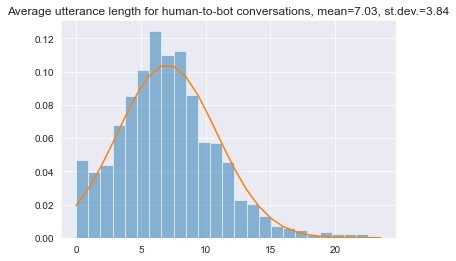

In [11]:
def get_hist_with_norm_dist(data, title, bins=25):
    _, bins, _ = plt.hist(data, bins=bins, density=1, alpha=0.5)
    mu, sigma = norm.fit(data)
    best_fit_line = norm.pdf(bins, mu, sigma)
    plt.plot(bins, best_fit_line)
    plt.title(f'{title}, mean={round(mu,2)}, st.dev.={round(sigma,2)}')

get_hist_with_norm_dist(calc_utt_len(hb_dialog), "Average utterance length for human-to-bot conversations")

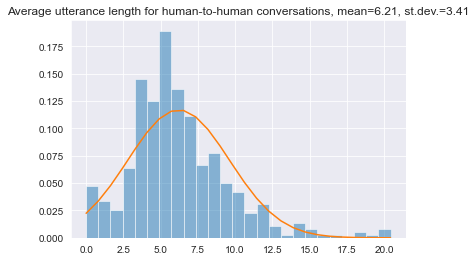

In [12]:
get_hist_with_norm_dist(calc_utt_len(hh_dialog), "Average utterance length for human-to-human conversations")

In [ ]:
human_utterances = []
bot_utterances = []

for dialog in hb_dialog:
    for th in dialog['thread']:
        text = wordpunct_tokenize(th['text'])
        user = [x for x in dialog['users'] if x['id'] == th['userId']][0]
        if user['userType'] == 'Human':
            human_utterances.append(th['text'])
        elif user['userType'] == 'Bot':
            bot_utterances.append(th['text'])

def calc_utt_len_sep(dataset):
    n_words, n_utt = [],[]
    word_in_utt = []
    word_in_utt_hier = []
    for d in dataset:
        cur_utt = 0
        cur_words = 0
        cur_w_i_u = []
        text = wordpunct_tokenize(d)
        cur_utt += 1
        cur_words += len(text)
        word_in_utt.append(len(text))
        cur_w_i_u.append(len(text))
        n_words.append(cur_words)
        n_utt.append(cur_utt)
        word_in_utt_hier.append(cur_w_i_u)
    word_per_utt = [float(w)/float(u) if u > 0 else 0 for w, u in zip(n_words, n_utt)]
    filter_word_per_utt = [f for f in word_per_utt if f < 25]
    return filter_word_per_utt

def calculate_utterance_length(dataset):
    for d in dataset:
        for th in d['thread']:
            text = wordpunct_tokenize(th['text'])
            th['UTT'] = text
            

get_hist_with_norm_dist(calc_utt_len_sep(human_utterances), 'Human utterances in conversations with bots')

In [ ]:
get_hist_with_norm_dist(calc_utt_len_sep(bot_utterances), 'Bot utterances')

### Noun Phrases

In [ ]:
# !pip install spacy
# !python -m spacy download en_core_web_sm
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()

# Just an example, has to be extended to the whole dataset
def get_NPs(dataset):
    result = []
    for d in dataset:
        for th in d['thread']:  
            phrases = set() 
            doc = nlp(th['text'])
            for nc in doc.noun_chunks:
                phrases.add(nc.text)
                phrases.add(doc[nc.root.left_edge.i:nc.root.right_edge.i+1].text) 
            th['NP'] = list(phrases)

In [ ]:
import pprint

pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(hb_dialog[0])
# heavy operation!
# get_NPs(hb_dialog)
# with open('train_hb_np.json', 'w') as f:
#     json.dump(hb_dialog, f)
# get_NPs(hh_dialog)
# with open('train_hh_np.json', 'w') as f:
#     json.dump(hh_dialog, f)

In [ ]:
with open("train_hb_np.json") as f:
    hb_dialog = json.load(f)
    
with open("train_hh_np.json") as f:
    hh_dialog = json.load(f)

In [ ]:
human_nps = []
bot_nps = []
for dialog in hb_dialog:
    for th in dialog['thread']:
        user = [x for x in dialog['users'] if x['id'] == th['userId']][0]
        if user['userType'] == 'Human':
            human_nps.append(th['NP'])
        elif user['userType'] == 'Bot':
            bot_nps.append(th['NP'])

len_human_nps = [len(np) for np in human_nps if len(np) < 25]         
len_bot_nps = [len(np) for np in bot_nps  if len(np) < 25]     

In [ ]:
get_hist_with_norm_dist(len_human_nps, 'Human NPs when talking to a bot')

In [ ]:
get_hist_with_norm_dist(len_bot_nps, 'Bot NPs')

In [ ]:
get_hist_with_norm_dist(len_bot_nps + len_human_nps, 'Human-to-bot NPs')

In [ ]:
hh_nps = []
for dialog in hh_dialog:
    for th in dialog['thread']:
        hh_nps.append(th['NP'])

len_hh_nps = [len(np) for np in hh_nps if len(np) < 25]         
get_hist_with_norm_dist(len_hh_nps, 'Human to Human NPs')

In [ ]:
# Add utterance length to dataset

calculate_utterance_length(hb_dialog)
calculate_utterance_length(hh_dialog)

with open('train_hb_np_utt.json', 'w') as f:
    json.dump(hb_dialog, f)

with open('train_hh_np_utt.json', 'w') as f:
    json.dump(hh_dialog, f)

In [ ]:
hh_dialog[0]

### Negative Log Likelihood

[Code from here](https://towardsdatascience.com/text-generation-with-python-and-gpt-2-1fecbff1635b)

From the paper:
> To calculate negative log-likelihood and entropy (avg. negative log-likelihood), we used a GPT-2 medium model (Radford et al., 2019), which was pre-trained on the English Webtext dataset and has 345M parameters. We fine-tuned this model on 130,000 examples of dialogue from our bot, where each example contained a single user utterance. This was divided into a training split with 91,000 examples and a validation split with 39,000 examples. During fine-tuning, we used the default hyperparameters and selected the model with the lowest negative log-likelihood loss (3.19) and had been trained for 4 epochs. The model was trained on a Titan RTX using a single GPU and 24 GB of memory. Training took 5 hours and 22 minutes.

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# initialize tokenizer and model from pretrained GPT2 model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

https://huggingface.co/docs/transformers/perplexity

In [ ]:
sequence = "Valeria is studying late at night because she worked all day long"
inputs = tokenizer.encode(sequence, return_tensors='pt')
outputs = model.generate(inputs, max_length=200, do_sample=True)
text = tokenizer.decode(outputs[0], skip_special_tokens=True)
text

In [ ]:
import math 

def calculatePerplexity(sentence,model,tokenizer):
        input_ids = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0) 
        input_ids = input_ids.to('cpu')
        with torch.no_grad():
            try:
                outputs = model(input_ids, labels=input_ids)
                loss, logits = outputs[:2]
                return math.exp(loss)
            except RuntimeError:
                return math.nan

model.eval()

In [ ]:
print(len(hb_dialog))

for i, d in enumerate(hb_dialog):
    for th in d['thread']:
        if len(th['text']) <= 1024:
            th['NLL'] = calculatePerplexity(th['text'], model, tokenizer)
    if i % 1000 == 0:
        print(i)
        

with open('train_hb_final.json', 'w') as f:
    json.dump(hb_dialog, f)

In [ ]:
print(len(hh_dialog))

for i, d in enumerate(hh_dialog):
    for th in d['thread']:
        if len(th['text']) <= 1024:
            th['NLL'] = calculatePerplexity(th['text'], model, tokenizer)
    if i % 1000 == 0:
        print(i)
        

with open('train_hh_final.json', 'w') as f:
    json.dump(hh_dialog, f)

In [ ]:
with open('train_hb_final.json', 'r') as f:
    hb_dialog = json.load(f)
    
with open('train_hh_final.json', 'r') as f:
    hh_dialog = json.load(f)

In [ ]:
import math

hh_nlls = []
for d in hh_dialog:
    for th in d['thread']:
        try:
            if th['NLL'] != math.nan and th['NLL'] < 1000:
                hh_nlls.append(th['NLL'])
        except KeyError:
            pass
get_hist_with_norm_dist(hh_nlls, 'Entropy for human-to-human dialogue', bins=10)

In [ ]:
hb_nlls = []
for d in hb_dialog:
    for th in d['thread']:
        try:
            if th['NLL'] != math.nan and th['NLL'] < 1000:
                hb_nlls.append(th['NLL'])
        except KeyError:
            pass
get_hist_with_norm_dist(hb_nlls, 'Entropy for human-to-bot dialogue', bins=10)

In [ ]:
bot_nlls = []
human_nlls = []
for d in hb_dialog:
    for th in d['thread']:
        try:
            if th['NLL'] != math.nan and th['NLL'] < 1000:
                user = [x for x in dialog['users'] if x['id'] == th['userId']][0]
                if user['userType'] == 'Human':
                    human_nlls.append(th['NLL'])
                elif user['userType'] == 'Bot':
                    bot_nlls.append(th['NLL'])
        except KeyError:
            pass
print(bot)
get_hist_with_norm_dist(bot_nlls, 'Bots entropy', bins=10)

In [ ]:
get_hist_with_norm_dist(human_nlls, 'Humans entropy', bins=10)

## Correlations

### Dataframe for human-to-human conversation

In [ ]:
import pandas as pd

In [ ]:
def construct_df(dataset, consider_bots=False):
    rows_list = []
    for d in dataset:
        row = {}
        user_1 = d['users'][0]
        user_2 = d['users'][1]
        if consider_bots:
            # Guarantee that user 1 is always human
            if user_1['userType'] == 'Bot':
                user_bot = user_1
                user_1 = user_2
                user_2 = user_bot
        
        eval_user_1 = [ev for ev in d['evaluation'] if ev['userId'] == user_1['id']][0]
        thread_user_1 = [th for th in d['thread'] if th['userId'] == user_1['id']]
        if thread_user_1:
            utt_user_1 = [th['UTT_LEN'] for th in thread_user_1]
            np_user_1 = [len(th['NP']) for th in thread_user_1]
            try:
                nll_user_1 = [th['NLL'] for th in thread_user_1]
            except KeyError:
                nll_user_1 = [0]
            if not consider_bots:
                row['breadth_user_1'] = eval_user_1['breadth']
                row['quality_user_1'] = eval_user_1['quality']
                row['engagement_user_1'] = eval_user_1['engagement']
            row['utt_user_1'] = sum(utt_user_1) / len(utt_user_1)
            row['np_user_1'] = sum(np_user_1) / len(np_user_1)
            row['nll_user_1'] = sum(nll_user_1) / len(nll_user_1)
        
        eval_user_2 = [ev for ev in d['evaluation'] if ev['userId'] == user_2['id']][0]
        thread_user_2 = [th for th in d['thread'] if th['userId'] == user_2['id']]
        if thread_user_2:
            utt_user_2 = [th['UTT_LEN'] for th in thread_user_2]
            np_user_2 = [len(th['NP']) for th in thread_user_2]
            try:
                nll_user_2 = [th['NLL'] for th in thread_user_2]
            except KeyError:
                nll_user_2 = [0]
            row['breadth_user_2'] = eval_user_2['breadth']
            row['quality_user_2'] = eval_user_2['quality']
            row['engagement_user_2'] = eval_user_2['engagement']
            row['utt_user_2'] = sum(utt_user_2) / len(utt_user_2)
            row['np_user_2'] = sum(np_user_2) / len(np_user_2)
            row['nll_user_2'] = sum(nll_user_2) / len(nll_user_2)
            
        rows_list.append(row)
    return rows_list
        
df = pd.DataFrame(data=construct_df(hh_dialog), columns=[
    'breadth_user_1',
    'quality_user_1',
    'engagement_user_1',
    'utt_user_1',
    'np_user_1',
    'nll_user_1',
    'breadth_user_2',
    'quality_user_2',
    'engagement_user_2',
    'utt_user_2',
    'np_user_2',
    'nll_user_2'
])

In [ ]:
df = df.fillna(0)

In [ ]:
!pip install seaborn
import seaborn as sns

sns.pairplot(df)

In [ ]:
sns.heatmap(df.corr(), annot=True)

In [ ]:
sns.heatmap(df.corr('kendall'), annot=True)

In [ ]:
sns.heatmap(df.corr('spearman'), annot=True)

In [ ]:
from scipy.stats import pearsonr, spearmanr, kendalltau

def calculate_pvalues(df, method='pearson'):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if method == 'pearson':
                pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
            elif method == 'spearman':
                pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
            elif method == 'kendall':
                pvalues[r][c] = round(kendalltau(df[r], df[c])[1], 4)
    return pvalues

calculate_pvalues(df)

In [ ]:
calculate_pvalues(df, 'spearman')

In [ ]:
calculate_pvalues(df, 'kendall')

All the NLL scores seem to be statistically insignificant.
Were they calculated correctly?

### Dataframe for human-to-bot conversation

In [ ]:
df_bots = pd.DataFrame(data=construct_df(hb_dialog), columns=[
    'utt_user_1',
    'np_user_1',
    'nll_user_1',
    'breadth_user_2',
    'quality_user_2',
    'engagement_user_2',
    'utt_user_2',
    'np_user_2',
    'nll_user_2'
])

In [ ]:
df_bots = df_bots.fillna(0)
df_bots.head()

In [ ]:
df_bots.corr()

In [ ]:
df_bots.corr('kendall')

In [ ]:
df_bots.corr('spearman')

In [ ]:
calculate_pvalues(df_bots)

> !!! NaNs above are produced because bots did not estimate humans !!!

> breadth_user_1 means "Estimate of user 1 conversation breadth from user 2"